# Generating Flower Images with GANs

## Description
In this project, I will train Generative Adversarial Networks (GANs) to create realistic images of flowers using the **Oxford 102 Flowers Dataset**. GANs are a type of neural network architecture designed to generate new, synthetic data that resembles a given dataset.

A GAN consists of two competing neural networks:
1. **Generator**:
   - Learns to create realistic images based on random input (noise).
2. **Discriminator**:
   - Learns to distinguish between real images from the dataset and synthetic images created by the Generator.

The training process is adversarial: the Generator improves to fool the Discriminator, while the Discriminator becomes better at identifying fake images. Over time, this "back-and-forth" competition results in the Generator producing highly realistic flower images.




### Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
import torchvision.utils as vutils
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.nn.modules.flatten import Flatten
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Initialize the transformer and download the dataset

In [2]:
# These transforms will be performed on every datapoint - in this example we want to transform every
# datapoint to a Tensor datatype, and perform normalization
image_size = 64
transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

flowers_train = torchvision.datasets.Flowers102('', split = "train", transform =transform, download=True)

100%|██████████| 345M/345M [00:18<00:00, 19.0MB/s]


Extracting flowers-102/102flowers.tgz to flowers-102


100%|██████████| 502/502 [00:00<00:00, 676kB/s]


100%|██████████| 15.0k/15.0k [00:00<00:00, 18.2MB/s]


Dataloaders

In [3]:
# We will create DataLoaders with a batch size of 102, allowing us to use 10 batches per Epoch
batch_size = 102
dataloaders = {'train': DataLoader(flowers_train, batch_size=batch_size)}

dataset_sizes = {'train': len(flowers_train)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 1020}


Lets take a moment and visualize the training images

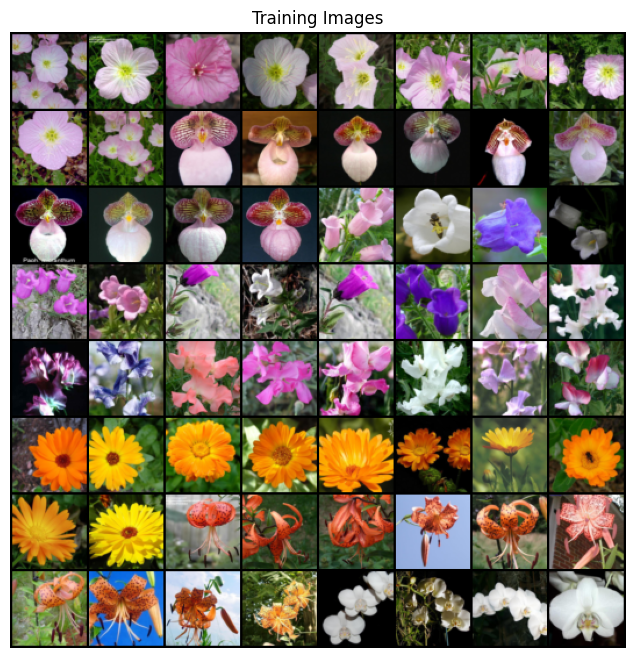

In [4]:
# Visualization function borrowed from: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

# Plot some training images
real_batch = next(iter(dataloaders["train"]))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Define the network paramaters

In [5]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

### Neural Network Architectures for GANs

#### **1. Discriminator**
The **Discriminator** is a Convolutional Neural Network (CNN) that classifies images as real or fake. It uses **LeakyReLU** as the activation function for intermediate layers and **Sigmoid** for the output layer to produce a probability score.

##### **Key Features**
- **Input**: Takes an image of size `(nc) x 64 x 64`, where `nc` is the number of color channels (e.g., 3 for RGB images).
- **Architecture**:
  - **Convolutional Layers**: Gradually reduces the spatial dimensions of the image while increasing the depth of feature maps.
  - **Batch Normalization**: Stabilizes training and improves convergence.
  - **LeakyReLU Activation**: Allows gradients to flow for negative inputs, mitigating vanishing gradient problems.
  - **Sigmoid Activation**: Outputs a value between 0 and 1, representing the probability that the input is real.
- **Output**: A single value indicating whether the input image is real (close to 1) or fake (close to 0).

##### **Architecture Overview**
- Input: `(nc) x 64 x 64`
- `(ndf) x 32 x 32`
- `(ndf * 2) x 16 x 16`
- `(ndf * 4) x 8 x 8`
- `(ndf * 8) x 4 x 4`
- Output: `1 x 1 x 1` (real/fake classification)

---

#### **2. Generator**
The **Generator** is a CNN that generates synthetic images from random noise vectors. It uses **ReLU** activation in intermediate layers and **Tanh** for the output layer to produce normalized pixel values.

##### **Key Features**
- **Input**: A random noise vector of size `(nz) x 1 x 1`, where `nz` is the latent space size.
- **Architecture**:
  - **Transpose Convolutional Layers**: Gradually increases the spatial dimensions of the image while reducing the depth of feature maps.
  - **Batch Normalization**: Stabilizes training and prevents mode collapse.
  - **ReLU Activation**: Ensures non-linear transformations for feature extraction and generation.
  - **Tanh Activation**: Produces output pixel values in the range `[-1, 1]`, matching the normalization of real images.
- **Output**: A synthetic image of size `(nc) x 64 x 64`.

##### **Architecture Overview**
- Input: `(nz) x 1 x 1`
- `(ngf * 8) x 4 x 4`
- `(ngf * 4) x 8 x 8`
- `(ngf * 2) x 16 x 16`
- `(ngf) x 32 x 32`
- Output: `(nc) x 64 x 64`

---

#### **Key Takeaways**
1. **Discriminator**:
   - Classifies images as real or fake.
   - Learns to differentiate between real and synthetic images.
2. **Generator**:
   - Produces realistic images from random noise.
   - Learns to mimic the distribution of the real dataset.

Together, the **Generator** and **Discriminator** form the adversarial framework of a GAN, where the Generator strives to produce realistic images to fool the Discriminator, and the Discriminator works to accurately classify real and fake images.


In [6]:
# Discriminator with LeakyReLU and Sigmoid activation
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.pipeline = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),  # Activation function
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),  # Activation function
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),  # Activation function
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),  # Activation function
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Final activation function
        )

    def forward(self, input):
        return self.pipeline(input)

# Generator with ReLU and TanH activation
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(Generator, self).__init__()
        self.pipeline = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),  # Activation function
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),  # Activation function
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),  # Activation function
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),  # Activation function
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()  # Final activation function
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.pipeline(input)


### Custom Weight Initialization for Generator and Discriminator

#### **Function: `weights_init`**
This function customizes the initialization of weights in the Generator (`netG`) and Discriminator (`netD`) networks to match the methodology described in the original GAN paper. Proper initialization helps stabilize training and improve convergence.

#### **Key Features**
1. **Layer-Specific Initialization**:
   - **Convolutional Layers** (`Conv`):
     - Initializes weights with a normal distribution (`mean=0.0`, `std=0.02`).
   - **Batch Normalization Layers** (`BatchNorm`):
     - Initializes weights with a normal distribution (`mean=1.0`, `std=0.02`).
     - Sets biases to zero (`constant=0`).

2. **Dynamic Layer Detection**:
   - Uses the class name (`classname`) to identify the type of layer and apply the corresponding initialization.


In [7]:
# custom weights initialization called on netG and netD
# This function initializes the weights of certain layers according to the distributions described in the original paper
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Model Instantiation and Initialization

#### **1. Instantiate Models**
- **Discriminator**:
  - **`netD = Discriminator(nc, ndf).to(device)`**:
    - Creates an instance of the Discriminator model.
    - Parameters:
      - `nc`: Number of channels in the input image (e.g., 3 for RGB).
      - `ndf`: Number of feature maps in the first convolutional layer.
    - Sends the model to the specified computation device (`GPU` if available, otherwise CPU).

- **Generator**:
  - **`netG = Generator(nc, nz, ngf).to(device)`**:
    - Creates an instance of the Generator model.
    - Parameters:
      - `nc`: Number of channels in the output image (e.g., 3 for RGB).
      - `nz`: Size of the latent vector (input noise).
      - `ngf`: Number of feature maps in the first transpose convolutional layer.
    - Sends the model to the specified computation device.

#### **2. Weight Initialization**
- **`netD.apply(weights_init)`**:
  - Applies the custom weight initialization function to the Discriminator.
- **`netG.apply(weights_init)`**:
  - Applies the custom weight initialization function to the Generator.

#### **3. Print Models**
- **`print(netD)` and `print(netG)`**:
  - Outputs the architecture of the Discriminator and Generator models for verification.

#### **Purpose**
- Ensures that both models are instantiated, initialized, and ready for training.
- Confirms that the weights are properly set according to the initialization scheme to enhance stability during training.

#### **Key Features**
- **Device Compatibility**:
  - Models are seamlessly transferred to the available computation device.
- **Custom Initialization**:
  - Provides stable and consistent weight initialization for both models.



In [8]:
# Instantiate the Discriminator and Generator
netD = Discriminator(nc, ndf).to(device)  # Create Discriminator and send to device
netG = Generator(nc, nz, ngf).to(device)  # Create Generator and send to device

# Apply the weights_init function to randomly initialize all weights
netD.apply(weights_init)
netG.apply(weights_init)

# Print the models
print(netD)
print(netG)

Discriminator(
  (pipeline): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
Generator(
  (pipeline): S

### Training the GAN

#### **Setup**
1. **Output Directory**:
   - **`output_dir`**: Directory to save the generated images at the end of each epoch.
   - Created using `os.makedirs` with `exist_ok=True` to ensure the directory exists without errors.

#### **Function: `train_GANs`**
Trains the Discriminator (`netD`) and Generator (`netG`) using adversarial learning over a specified number of epochs.

---

#### **Key Features**
1. **Loss Tracking**:
   - Tracks the Discriminator's (`D`) and Generator's (`G`) losses for monitoring progress.

2. **Training Steps**:
   - **Update the Discriminator**:
     - Processes real images and calculates the loss for correctly identifying them as real.
     - Processes fake images generated by the Generator and calculates the loss for identifying them as fake.
     - Updates the Discriminator’s weights based on combined loss.
   - **Update the Generator**:
     - Generates fake images and calculates the loss for fooling the Discriminator into classifying them as real.
     - Updates the Generator's weights to improve its ability to generate realistic images.

3. **Performance Metrics**:
   - **`D(x)`**: Average confidence of the Discriminator on real images.
   - **`D(G(z))`**: Discriminator’s confidence on fake images before and after Generator updates.

4. **Image Generation**:
   - At the end of each epoch, generates and saves a grid of synthetic images created by the Generator.

---

#### **Workflow**
1. **Epoch Loop**:
   - Iterates over the specified number of epochs (`num_epochs`).
2. **Batch Processing**:
   - For each batch in the training dataset:
     - Updates the Discriminator and Generator.
     - Tracks and prints losses and performance metrics periodically.
3. **Image Saving**:
   - Saves a grid of generated images for visual progress at the end of every epoch.

---

#### **Outputs**
1. **Trained Models**:
   - Returns the trained Discriminator (`netD`) and Generator (`netG`).
2. **Training Curves**:
   - Contains the loss values for both networks over all batches and epochs.
3. **Generated Images**:
   - Synthetic images saved as PNG files in the `generated_images` directory for visual inspection.

---

#### **Purpose**
- Optimizes the Generator to produce realistic images that can fool the Discriminator.
- Improves the Discriminator's ability to distinguish between real and fake images.
- Tracks training progress and generates visual results for evaluation.

---

#### **Benefits**
- **Adversarial Training**:
  - The competing dynamics between Generator and Discriminator improve the quality of generated images.
- **Visualization**:
  - Saves generated images at each epoch to monitor the Generator's progress visually.
- **Performance Tracking**:
  - Logs losses and confidence scores, enabling detailed analysis of training dynamics.


In [9]:
import os

# Directory to save generated images
output_dir = "generated_images"
os.makedirs(output_dir, exist_ok=True)

def train_GANs(netD, netG, dataloaders, dataset_sizes, criterion, optimizerD, optimizerG, num_epochs=25):
    since = time.time()

    # Keep track of losses
    training_curves = {'D': [], 'G': []}
    phase = 'train'

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for i, inputs in enumerate(dataloaders[phase], 0):

            ############################
            # (1) Update D network
            ###########################
            optimizerD.zero_grad()

            # Format real batch
            real_cpu = inputs[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            # Train with fake batch
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            ############################
            # (2) Update G network
            ###########################
            optimizerG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            # Save losses
            training_curves['D'].append(errD.item())
            training_curves['G'].append(errG.item())

            # Print progress every 100 batches
            if i % 100 == 0:
                print(f'[Epoch {epoch+1}/{num_epochs}] Batch {i}/{len(dataloaders[phase])} '
                      f'D Loss: {errD.item():.4f}  G Loss: {errG.item():.4f}  '
                      f'D(x): {D_x:.4f}  D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}')

        # Generate images at the end of every epoch and save them
        with torch.no_grad():
            fake = netG(torch.randn(64, nz, 1, 1, device=device)).detach().cpu()
            plt.figure(figsize=(8, 8))
            plt.axis("off")
            plt.title(f"Epoch {epoch+1}")
            plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1, 2, 0)))
            plt.savefig(f"{output_dir}/epoch_{epoch+1}.png")
            plt.close()

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return netD, netG, training_curves


### Training Configuration and Hyperparameters

#### **1. Number of Training Epochs**
- **`num_epochs = 250`**:
  - Specifies the number of complete passes through the training dataset.
  - Initially, a smaller value (e.g., 100) can be used for debugging and experimentation before scaling up.

#### **2. Learning Rate**
- **`lr = 0.0001`**:
  - Sets the step size for updating model weights during training.
  - A low learning rate ensures stable and gradual convergence.

#### **3. Adam Optimizer Beta Parameter**
- **`beta1 = 0.5`**:
  - A momentum term for the Adam optimizer that influences the moving average of gradients.
  - Helps stabilize GAN training by smoothing gradient updates.

#### **4. Labels**
- **`real_label = 1.0`**:
  - Conventionally assigns the label `1` to real images during training.
- **`fake_label = 0.0`**:
  - Conventionally assigns the label `0` to fake images generated by the Generator.

#### **5. Latent Vector for Visualization**
- **`fixed_noise`**:
  - A fixed batch of random noise vectors used as input to the Generator.
  - Enables consistent visualization of the Generator's progress across epochs.

#### **6. Loss Function**
- **`criterion = nn.BCELoss()`**:
  - Binary Cross-Entropy Loss function calculates the error for real vs. fake image classification.
  - Guides the Discriminator and Generator during training.

#### **7. Optimizers**
- **`optimizerD`**:
  - Adam optimizer for the Discriminator:
    - Learning rate: `lr = 0.0001`
    - Momentum term: `betas = (0.5, 0.999)`
- **`optimizerG`**:
  - Adam optimizer for the Generator:
    - Same configuration as `optimizerD`.

#### **8. Training**
- **`train_GANs`**:
  - Trains the Discriminator and Generator using adversarial learning.
  - Tracks training progress and returns the trained models (`netD`, `netG`) along with loss curves.

---

#### **Purpose**
This configuration:
- Sets up the training environment for efficient and stable GAN optimization.
- Balances hyperparameters to improve convergence and stability during adversarial training.

#### **Outputs**
- **Trained Models**:
  - Discriminator and Generator after `num_epochs` of training.
- **Training Curves**:
  - Loss trends for both networks over the course of training.
- **Generated Images**:
  - Synthetic images created using `fixed_noise` to monitor the Generator's progress visually.

---

#### **Benefits**
- **Stability**:
  - The use of carefully tuned hyperparameters prevents mode collapse and oscillations common in GAN training.
- **Consistency**:
  - Fixed noise vectors ensure consistent visual evaluation across epochs.
- **Optimization**:
  - Adam optimizers and Binary Cross-Entropy Loss provide robust mechanisms for training adversarial networks.


In [ ]:
# Number of training epochs
num_epochs = 250 #Try 100 or so, once working

# Learning rate for optimizers
lr =  0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Establish convention for real and fake labels during training
real_label = 1.0  # Real images are labeled with 1
fake_label = 0.0  # Fake images are labeled with 0

# Create a fixed batch of latent vectors to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)


# TODO: Initialize BCELoss function
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Train the model. We also will store the results of training to visualize
netD, netG, training_curves = train_GANs(netD, netG, dataloaders, dataset_sizes,
                                    criterion, optimizerD, optimizerG, num_epochs=num_epochs)


Epoch 1/250
----------
[Epoch 1/250] Batch 0/10 D Loss: 1.5698  G Loss: 2.9768  D(x): 0.5169  D(G(z)): 0.4904/0.0716

Epoch 2/250
----------
[Epoch 2/250] Batch 0/10 D Loss: 0.4535  G Loss: 4.9758  D(x): 0.8571  D(G(z)): 0.2060/0.0101

Epoch 3/250
----------
[Epoch 3/250] Batch 0/10 D Loss: 0.4124  G Loss: 6.4835  D(x): 0.8526  D(G(z)): 0.1691/0.0027

Epoch 4/250
----------
[Epoch 4/250] Batch 0/10 D Loss: 0.2338  G Loss: 7.0109  D(x): 0.8743  D(G(z)): 0.0545/0.0014

Epoch 5/250
----------
[Epoch 5/250] Batch 0/10 D Loss: 0.1720  G Loss: 11.3838  D(x): 0.8654  D(G(z)): 0.0013/0.0000

Epoch 6/250
----------
[Epoch 6/250] Batch 0/10 D Loss: 0.1602  G Loss: 8.8696  D(x): 0.9460  D(G(z)): 0.0917/0.0002

Epoch 7/250
----------
[Epoch 7/250] Batch 0/10 D Loss: 0.1047  G Loss: 8.0470  D(x): 0.9188  D(G(z)): 0.0092/0.0004

Epoch 8/250
----------
[Epoch 8/250] Batch 0/10 D Loss: 0.0549  G Loss: 8.2985  D(x): 0.9743  D(G(z)): 0.0268/0.0004

Epoch 9/250
----------
[Epoch 9/250] Batch 0/10 D Loss

Visualize Results

### Visualizing Training Loss for Generator and Discriminator

#### **Description**
This visualization plots the Generator (`G`) and Discriminator (`D`) losses during training to monitor their progress and assess the stability of the adversarial learning process.

#### **Key Features**
1. **Plot Components**:
   - **Title**: Clearly indicates that the graph represents the losses of the Generator and Discriminator during training.
   - **X-axis**: Represents the number of training iterations (batches processed).
   - **Y-axis**: Represents the loss values for both networks.
   - **Legend**: Differentiates between the Generator (`G`) and Discriminator (`D`) losses.

2. **Data Sources**:
   - **`training_curves['G']`**: Loss values for the Generator, tracked during training.
   - **`training_curves['D']`**: Loss values for the Discriminator, tracked during training.

3. **Figure Details**:
   - **Figure Size**: Enlarged to `10x5` for clear visualization.
   - **Labels and Legends**: Enhance interpretability by labeling axes and identifying the losses for `G` and `D`.


In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(training_curves['G'] ,label="G")
plt.plot(training_curves['D'] ,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloaders['train']))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Generate Fake images
img_list = []
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()